<a href="https://colab.research.google.com/github/hyeok8055/Captcha/blob/main/%EC%BA%A1%EC%B0%A8_%EB%9A%AB%EA%B8%B0_V1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Version Log
### 최초 제작자 : 윤주혁
### 데이터 수집에 돈낸 사람 : 윤주혁
### 데이터 전처리 및 학습 참여 : 김보찬
### Modeling : 오민기
* * *
### Initial
> * val_loss =3.11 
> * cap2022제외 정확도 100%
* * *
### 1.1 Version
> * 라벨 데이터 원핫 인코딩 코드 정리
* * *
### 1.2 Version
> * 코드정리
> * 모델 수정 및 성능 개선 val_loss = 0.24079
* * *

In [ ]:
#구글 드라이브 다운로드 패키지
from google_drive_downloader import GoogleDriveDownloader as gdd
#구글 드라이브 공유 파일 다운로드
gdd.download_file_from_google_drive(file_id='', #공유 파일 id  # 보안을 위해 고유 id 제거
                                    dest_path='raw/raw_2000.zip', #저장할 이름
                                    unzip=True) #압축 풀기

Unzipping...Done.


In [ ]:
!rm raw/raw_2000.zip

## 데이터 전처리

In [ ]:
import os, cv2, time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Concatenate, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
path = '/content/raw/'
img_list = os.listdir(path)
img_list[0]

'2wrf.png'

In [ ]:
max_output_value = 255
neighborhood_size = 99
subtract_from_mean = 10
save_path = '/content/preprocessed/'

def img_preprocessing(img_list, path, save_path): 

    if os.path.isdir(save_path):
        print("already exist")
    else:
        os.mkdir(save_path)
    
    for img_name in img_list:
        image = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE) # 흑백 이미지로 로드
        image = image[:,:130]
        image = cv2.adaptiveThreshold(image, max_output_value,
                                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
                                                neighborhood_size, subtract_from_mean) # 적응적 임계처리를 적용
        cv2.imwrite(os.path.join(save_path, img_name), image) # 이미지를 저장
        
img_preprocessing(img_list, path, save_path)

## 머신러닝 부분

In [ ]:
img_list = os.listdir(save_path)

def img_to_np(img_list, path):  
    img_array = []
    for img_name in img_list:
      try:
        img = Image.open(os.path.join(path, img_name)).convert('L')
        # img = img.resize((130, 130))
        img_array.append(np.asarray(img))
      except:
        continue
    images = np.array(img_array)
    return images

x_train = img_to_np(img_list, save_path)
x_train = x_train.astype(np.float32) / 255.

print(x_train.shape)

(2011, 40, 130)


### 라벨 데이터 원핫 인코딩

In [ ]:
temp = [x.split('.')[0] for x in img_list] 

strings = []
for st in temp:
    strings += list(st)
    
index = np.array(list(set(strings)))
index

array(['2', 'p', 'm', 'f', '7', 'n', 'g', 'y', '3', 'e', '5', 'r', 'k',
       '8', '4', 'x', 'h', 'a', 'b', 'd', '6', 'c', 'w'], dtype='<U1')

In [ ]:
res = []
y_train = []

for st in temp:
    t = []
    for ch in list(st):
        for i, c in enumerate(index):
            if ch == c:
                t.append(i)
                break
    res.append(t)



for r in res:
    y_train.append(tf.one_hot(r, 23))

y_train = np.asarray(y_train)

In [ ]:
# dense_train = x_train.copy()
x_train=x_train[...,tf.newaxis]

In [ ]:
H, W, C = 40, 130, 1
N_LABELS = 23
D = 4

In [ ]:
input_layer = Input(shape=(H, W, C))

# Kernel Size = 3
kernel_3 = Conv2D(32, (3, 3) , activation='relu', kernel_initializer="he_normal")(input_layer)
kernel_3 = MaxPooling2D((2, 2))(kernel_3)
kernel_3 = Conv2D(64, (3, 3), activation='relu',  kernel_initializer="he_normal")(kernel_3)
kernel_3 = MaxPooling2D((2, 2),)(kernel_3)
kernel_3 = Conv2D(128, (3, 3), activation='relu',  kernel_initializer="he_normal")(kernel_3)
kernel_3 = MaxPooling2D((2, 2))(kernel_3)
kernel_3 = Flatten()(kernel_3)

# Kernel Size = 4
kernel_4 = Conv2D(32, 5, activation='relu', kernel_initializer="he_normal")(input_layer)
kernel_4 = MaxPooling2D((2, 2))(kernel_4)
kernel_4 = Conv2D(64, 5, activation='relu',  kernel_initializer="he_normal")(kernel_4)
kernel_4 = MaxPooling2D((2, 2),)(kernel_4)
kernel_4 = Conv2D(128, 5, activation='relu',  kernel_initializer="he_normal")(kernel_4)
kernel_4 = MaxPooling2D((2, 2),)(kernel_4)
kernel_4 = Flatten()(kernel_4)

# Concat
concat = Concatenate()([kernel_3, kernel_4])
concat = Dense(2048, activation="relu", kernel_initializer="he_normal")(concat)
concat = BatchNormalization()(concat)
concat = Dropout(0.2)(concat)
concat = Dense(512, activation="relu", kernel_initializer="he_normal")(concat)
# concat = BatchNormalization()(concat)
# concat = Dropout(0.2)(concat)
concat = Dense(D * N_LABELS, activation='softmax')(concat)
output = Reshape((D, N_LABELS))(concat)


model = Model(inputs=[input_layer], outputs=output)


model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40, 130, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 38, 128, 32)  320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 36, 126, 32)  832         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 19, 64, 32)   0           conv2d_12[0][0]                  
____________________________________________________________________________________________

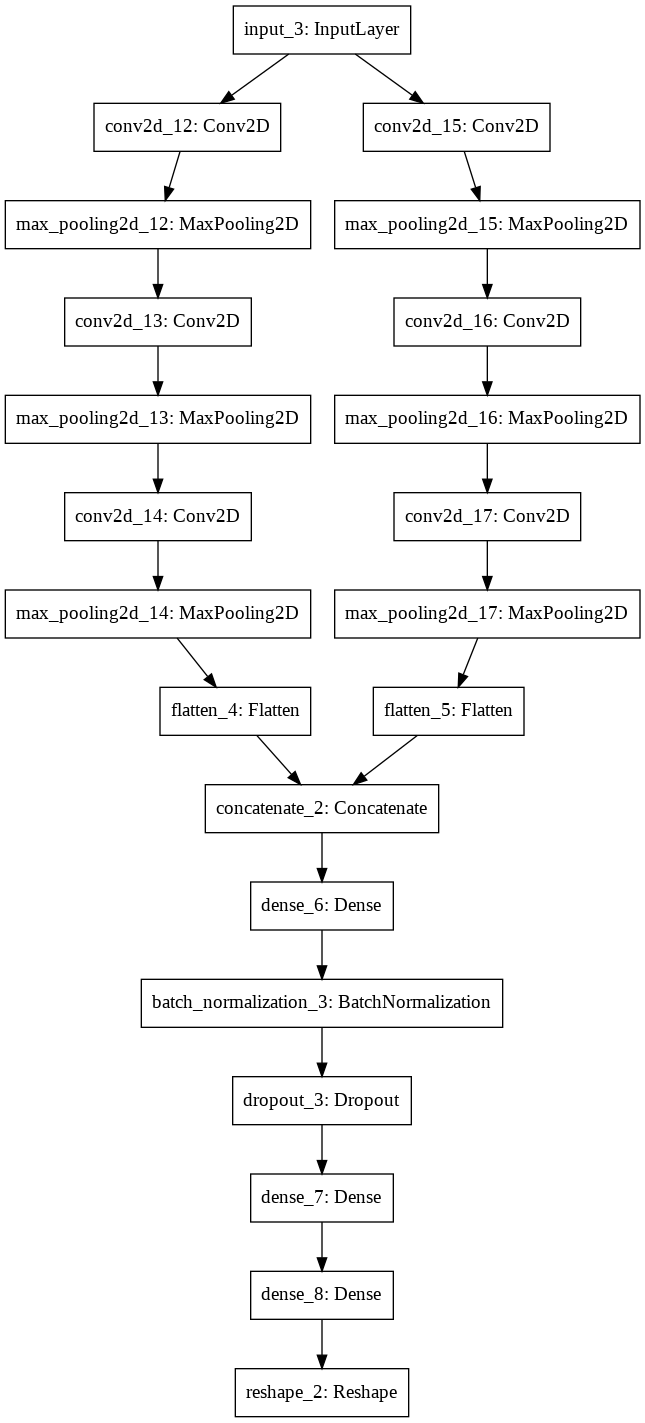

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_path = "/content/my_checkpoint.ckpt"
mc = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
ea =  EarlyStopping(patience=10, monitor='val_loss', verbose=1)

In [ ]:
batch_size = 64
# train_gen = get_data_generator(X_train, Y_train, for_training=True, batch_size=batch_size)
# valid_gen = get_data_generator(X_valid, Y_valid, for_training=True, batch_size=valid_batch_size)


model.fit(x_train, y_train, validation_split=0.2, batch_size=32, epochs=100, callbacks=[mc, ea], verbose=1)

Epoch 1/100
51/51 [==============================] - 4s 48ms/step - loss: 1.8660 - acc: 0.4806 - val_loss: 10.5065 - val_acc: 0.1346

Epoch 00001: val_loss improved from inf to 10.50655, saving model to /content/my_checkpoint.ckpt
Epoch 2/100
51/51 [==============================] - 2s 39ms/step - loss: 0.3161 - acc: 0.9182 - val_loss: 5.3799 - val_acc: 0.3145

Epoch 00002: val_loss improved from 10.50655 to 5.37985, saving model to /content/my_checkpoint.ckpt
Epoch 3/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0671 - acc: 0.9907 - val_loss: 2.8161 - val_acc: 0.3976

Epoch 00003: val_loss improved from 5.37985 to 2.81608, saving model to /content/my_checkpoint.ckpt
Epoch 4/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0206 - acc: 0.9991 - val_loss: 1.6873 - val_acc: 0.5794

Epoch 00004: val_loss improved from 2.81608 to 1.68734, saving model to /content/my_checkpoint.ckpt
Epoch 5/100
51/51 [==============================] - 2s 39ms/step - l

In [ ]:
model = model.load_weights(checkpoint_path)

35ha

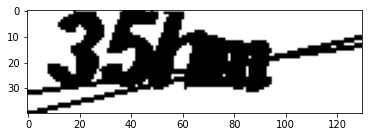

In [ ]:
image = cv2.imread('/content/tt.png', cv2.IMREAD_GRAYSCALE) # 흑백 이미지로 로드
image_cropped = image[:,:130]
image_binarized = cv2.adaptiveThreshold(image_cropped, max_output_value,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
                                        neighborhood_size, subtract_from_mean) # 적응적 임계처리를 적용
plt.imshow(image_binarized,cmap='gray')        

input = image_binarized/255.0
# input2 = input.reshape([1,40,130])
input_conv = input.reshape([1,40,130,1])
output = model.predict(input_conv)
for out in output[0]:
    print(index[np.argmax(out)],end='')

ne8d